In [0]:
from fastai.text import *


In [0]:
df['en'] = df['en'].apply(lambda x:x.lower())
df['fr'] = df['fr'].apply(lambda x:x.lower())

In [0]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [0]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [0]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [0]:
!pip install -U -q PyDrive

In [0]:
from google.colab import drive


In [7]:
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('/content/drive/My Drive/questions_easy.csv')

In [23]:
df.head()

,en,fr
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


In [0]:
df['en'] = df['en'].apply(lambda x:x.lower())
df['fr'] = df['fr'].apply(lambda x:x.lower())

In [0]:
src = Seq2SeqTextList.from_df(df, path = '.', cols='fr').split_by_rand_pct(seed=42).label_from_df(cols='en', label_cls=TextList)

In [27]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)
len(src.train) + len(src.valid)


48350

In [31]:
data = src.databunch()
data.save('/content/drive/My Drive/questions_easy_seq2seq_databunch')
data


Seq2SeqDataBunch;

Train: LabelList (38704 items)
x: Seq2SeqTextList
xxbos qu’est - ce que la lumière ?,xxbos où sommes - nous ?,xxbos d'où venons - nous ?,xxbos que ferions - nous sans elle ?,xxbos quel est le groupe autochtone principal sur l’île de vancouver ?
y: TextList
xxbos what is light ?,xxbos who are we ?,xxbos where did we come from ?,xxbos what would we do without it ?,xxbos what is the major aboriginal group on vancouver island ?
Path: .;

Valid: LabelList (9646 items)
x: Seq2SeqTextList
xxbos quels pourraient être les effets sur l’instrument de xxunk et sur l’aide humanitaire qui ne sont pas co - xxunk ?,xxbos quand la source primaire a - t - elle été créée ?,xxbos pourquoi tant de soldats ont - ils fait xxunk de ne pas voir ce qui s'est passé le 4 et le 16 mars ?,xxbos quels sont les taux d'impôt sur le revenu au canada pour 2007 ?,xxbos pourquoi le programme devrait - il intéresser les employeurs et les fournisseurs de services ?
y: TextList
xxbos what would be the resu

In [11]:
data = load_data('/content/drive/My Drive/questions_easy_seq2seq_databunch')
data.show_batch()


text,target
"xxbos qu’en est - il du fardeau supplémentaire que l’on fait porter aux familles , et surtout aux femmes , qui xxunk la plupart des soins à la maison ?","xxbos what about the increased demands placed on families , especially women , who provide most of the care at home ?"
xxbos xxunk 9 - quelle est la méthodologie appropriée pour les essais cliniques portant sur le traitement valvulaire par voie xxunk et quel est le groupe de patients optimal ?,xxbos what is the appropriate clinical trial design for xxunk valve treatment and what is the optimum patient population ?
"xxbos quelles sont les conséquences des mesures de la pac pour la diversité génétique , et quelles sont les conséquences à prévoir du xxunk et de la xxunk environnementale ?","xxbos what impact do cap measures have in terms of genetic diversity , and what impact can be expected from xxunk and cross - compliance ?"
xxbos pourquoi le bureau de l'accès médical au xxunk a - t - il changé son nom à la division de l'accès à la marihuana à des fins médicales ?,xxbos why has the office of xxunk medical access changed its name to marihuana medical access division ( xxunk ) ?
"xxbos quel changement de circonstances xxunk ce qui , d'après la détermination de la commission , était un statu quo non xxunk en une situation de xxunk important xxunk ?",xxbos what change in circumstances would transform what the commission determined to be a non - xxunk status quo into a situation of imminent material injury ?


In [12]:
! pip install fastText

     |████████████████████████████████| 61kB 3.6MB/s 
  Created wheel for fastText: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2384393 sha256=1e7a51f18224f54f717885ac6f9ffe59bf7c3bce7d9e5c0e1044de4090801b5f
  Stored in directory: /root/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fastText


In [0]:
! rm -rf .fastai

In [0]:
import fasttext as ft


In [0]:
path = Config().data_path()


In [41]:
path

PosixPath('/root/.fastai/data')

In [42]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz -P {path}

--2019-11-02 10:48:48--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘/root/.fastai/data/cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  10.2MB/s    in 7m 3s   

2019-11-02 10:55:53 (10.1 MB/s) - ‘/root/.fastai/data/cc.en.300.bin.gz’ saved [4503593528/4503593528]

--2019-11-02 10:55:55--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [45]:
! gunzip {path}/cc.en.300.bin.gz


gzip: /root/.fastai/data is a directory -- ignored
gzip: / is a directory -- ignored
gzip: cc.fr.300.bin.gz: No such file or directory


In [51]:
path

PosixPath('/root/.fastai/data')

In [56]:
! ls -lah /root/.fastai/data

total 11G
drwxr-xr-x 2 root root 4.0K Nov  2 11:06 .
drwxr-xr-x 3 root root 4.0K Nov  2 10:48 ..
-rw-r--r-- 1 root root 6.8G Jan 18  2019 cc.en.300.bin
-rw-r--r-- 1 root root 4.2G Jan 18  2019 cc.fr.300.bin.gz


In [0]:
! gunzip {path}/cc.fr.300.bin.gz

In [58]:

fr_vecs = ft.load_model(str((path/'cc.fr.300.bin')))
en_vecs = ft.load_model(str((path/'cc.en.300.bin')))

In [0]:
def create_emb(vecs, itos, em_sz=300, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    vec_dic = {w:vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = tensor(vec_dic[w])
        except: miss.append(w)
    return emb

In [0]:

emb_enc = create_emb(fr_vecs, data.x.vocab.itos)
emb_dec = create_emb(en_vecs, data.y.vocab.itos)

In [61]:
emb_enc.weight.size(), emb_dec.weight.size()


(torch.Size([11336, 300]), torch.Size([8144, 300]))

In [62]:
torch.save(emb_enc, '/content/drive/My Drive/fr_emb.pth')
torch.save(emb_dec, '/content/drive/My Drive/en_emb.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
emb_enc = torch.load('/content/drive/My Drive/fr_emb.pth')
emb_dec = torch.load('/content/drive/My Drive/en_emb.pth')

In [0]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, 
                    nh, out_sl, 
                    nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
        
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [0]:
xb,yb = next(iter(data.valid_dl))


In [0]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 30)


In [0]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [0]:
learn = Learner(data, rnn, loss_func=seq2seq_loss)


In [23]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


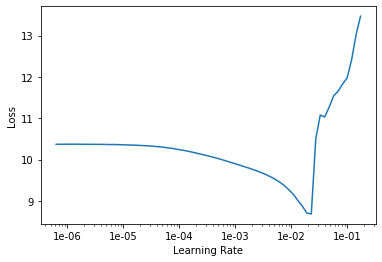

In [69]:
learn.recorder.plot()
